In [11]:
from nutils import*
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors, collections, cm
import vtk
import image_based_analysis as im

In [160]:
def SortPointsByAngle(pts_array):
    pts = pts_array.copy()
    angles = np.zeros([len(pts)])
    u = pts[0]
    u /= np.linalg.norm(u)
    u = np.array([u[0], u[1], 0])
    for i in range(len(pts)):
        v = pts[i]
        v /= np.linalg.norm(v)
        v = np.array([v[0], v[1], 0])
        s = np.sign( np.cross(u,v)[2] )
        angles[i] = s * np.arccos(np.clip(v.dot(u),-1,1))
        if s < 0:
            angles[i] += 2 * np.pi
    inds = angles.argsort()
    return inds

def BuildConnectivityArray(npts):
    connectivity = np.zeros([npts,2], dtype=int)
    for i in range(npts):
        connectivity[i] = [i, (i+1) % npts]
    return connectivity

def PlotMesh(topo, geom, f, n=5, col='w', **kwargs):
    fig, ax = im.CreatePlot()
    im.PlotMesh(ax, topo, geom, f=f, n=n, **kwargs)
    im.PlotMeshWireframe(ax, topo, geom, color=col)
    return ax

class MaterialModel:
    def __init__(self, tissue_map, E_map, nu_map):
        self.tissue_map = tissue_map
        new_E_map = {}
        new_nu_map = {}
        for key in E_map:
            new_E_map[tissue_map[key]] = E_map[key]
        for key in nu_map:
            new_nu_map[tissue_map[key]] = nu_map[key]
        self.E_map = im.IM_LabelMap(new_E_map)
        self.nu_map = im.IM_LabelMap(new_nu_map)
    def E(self, key):
        return self.E_map[self.tissue_map[key]]
    def nu(self, key):
        return self.nu_map[self.tissue_map[key]]

class Circle:
    def __init__(self, plane, radius):
        self.plane = plane
        self.radius = radius
        
class MaterialPropertiesLabel(function.Array):
    @types.apply_annotations
    def __init__(self, material_model, *args:function.asarrays):
        self.material_model = material_model
        retval = self.evalf(*[np.ones((), dtype=arg.dtype) for arg in args])
        shapes = set(arg.shape for arg in args)
        assert len(shapes) == 1, 'pointwise arguments have inconsistent shapes'
        shape, = shapes
        self.args = args
        super().__init__(args=args, shape=shape, dtype=retval.dtype)
        
    def evalf(self, wall_sdf, autoplaque):
        vals = autoplaque.copy()
        vals[np.logical_and(autoplaque==self.material_model.tissue_map["background"] , wall_sdf < 0)] = self.material_model.tissue_map["artery"]
        return vals    
        
    def _derivative(self, var, seen):
        return np.zeros(self.shape + var.shape)

class OverwriteRegion(function.Array):
    @types.apply_annotations
    def __init__(self, test, *args:function.asarrays):
        print(test.shape)
        retval = self.evalf(*[np.ones((), dtype=arg.dtype) for arg in args])
        shapes = set(arg.shape for arg in args)
        assert len(shapes) == 1, 'pointwise arguments have inconsistent shapes'
        shape, = shapes
        self.args = args
        super().__init__(args=args, shape=shape, dtype=retval.dtype)
        
    def evalf(self, f, g, indicator):
        return np.array([ff if i > 0 else gg for ff, gg, i in zip(f,g, indicator)]) 
        
    def _derivative(self, var, seen):
        return np.zeros(self.shape + var.shape)

def ScaleTissueMap(tissue_map):
    scaled_tissue_map = {}
    i = 0
    for key in tissue_map:
        scaled_tissue_map[tissue_map[key]] = i
        i+=1
    return im.IM_LabelMap(scaled_tissue_map)

def WriteTriMesh(fname, topo=None, geom=None, xvals=[], tri=[], f=function.asarray(0), fvals=[], res=2):
    if xvals == []:
        bez = topo.sample('bezier', res)
        xvals = bez.eval(geom)
        tri = bez.tri
    n = np.array([len(xvals[0]),len(xvals), len(tri)])
    if fvals == []:
        fvals = bez.eval(f)
    with open(fname, "ab") as f:
        f.truncate(0)
        np.savetxt(f, n)
        f.write(b";\n")
        np.savetxt(f, xvals, delimiter=',')
        f.write(b";\n")
        np.savetxt(f, tri, delimiter=',')
        f.write(b";\n")
        np.savetxt(f, fvals)
        

In [13]:
# INPUTS

# Set data paths
lumen_flow_sim_path = "data/flow_sim.vtu"
autoplaque_img_path = "data/autoplaque.mha"
wallsdf_img_path = "data/outer_wall.mha"

# Define Material Model
tissue_map = {"blood" : -1 , "background" : 0, "artery" : 33, "fibrous" : 75, "calcified" : 225}
nu_map = {"blood" : 0, "background" : 0.4, "artery" : 0.27, "fibrous" : 0.27, "calcified" : .31}
E_map = {"blood" : 2 / 1000, "background" : 60 / 1000, "artery" : 100 / 1000, "fibrous" : 1000 / 1000, "calcified" : 10000 / 1000}

# Define Material properties projection degree
p_conv = 1

# Define slice
origin = (39.35025102748692, -182.88678578819045, 635.1077093084257)
normal = (0.16669412398742134, -0.9856447804529322, 0.026784991953651572)
radius = 4

# Define Bounding Volume size
h = 1

# Define Mesh size
Nu = 2
Nv = 2
L = 2

# Define refinement scheme
nref = 1
delta = 1 / 20
nqref = 1

# Define basis degree
p = 2

# Define stiffness Quadrature Rule
q = 3

# Define Immersed Boundary Quadrature Rule
qu = 1

# Define post processing projection degree
p_post = 1

# Define Export parameters
plots = ["disp_smooth", "vonmises_smooth"]
res = 10

In [14]:
# Process Inputs

# Build Mesh
lumen_mesh = im.ReadVTKMesh(lumen_flow_sim_path)

# Build Images
autoplaque_img = im.IM_Image_CreateFromVTKMetaImageFile(autoplaque_img_path)
wallsdf_img = im.IM_Image_CreateFromVTKMetaImageFile(wallsdf_img_path)

# Build Material Model
material_model = MaterialModel(tissue_map, E_map, nu_map)

# Build Slicing Region
plane = im.BuildVTKPlane(origin, normal)
slice_region = Circle(plane, radius)

In [15]:
# Build Immersed Lumen Slice Mesh, Gamma

# Slice Mesh
lumen_slice = im.SliceVTKMesh(lumen_mesh, plane)

# Get Slice Data
pts = im.GetVTKMeshPoints(lumen_slice)
tractions = im.GetVTKMeshData(lumen_slice, "Traction")
normals = im.GetVTKMeshData(lumen_slice, "normal")

# Transform data to local coordinates
pts_transformed = im.VTKPlaneTransformPoints(plane, pts)
tractions_transformed = im.VTKPlaneTransformVectors(plane, tractions)
normals_transformed = im.VTKPlaneTransformVectors(plane, normals)

# filter slice to isolate a single artery
filter_radius = 1
pts_filtered = np.array([pt for pt in pts_transformed if np.linalg.norm(pt) < filter_radius])
tractions_filtered = np.array([t for t, pt in zip(tractions_transformed,pts_transformed) if np.linalg.norm(pt) < filter_radius])
normals_filtered = np.array([t for t, pt in zip(normals_transformed,pts_transformed) if np.linalg.norm(pt) < filter_radius])

# sort data by angle
inds = SortPointsByAngle(pts_filtered)
sorted_pts = pts_filtered[inds]
sorted_tractions = tractions_filtered[inds]
sorted_normals = normals_filtered[inds]

# create lumen slice mesh
gamma = function.Namespace()
lumen_polygon = im.IM_Polygon(sorted_pts)
gamma_topo, gamma.xi = lumen_polygon.ToNutilsMesh()

# Create linear basis
gamma.linbasis = gamma_topo.basis('spline',degree=1)

# Create Traction Function on Lumen Mesh
gamma.tu = gamma.linbasis.dot(sorted_tractions[:,0])
gamma.tv = gamma.linbasis.dot(sorted_tractions[:,1])
gamma.traction_i = '<tu, tv>_i'

# Create Traction Function on Lumen Mesh
gamma.nu = gamma.linbasis.dot(sorted_normals[:,0])
gamma.nv = gamma.linbasis.dot(sorted_normals[:,1])
gamma.normal_i = '<nu, nv>_i'

# Define Inverse Plane Transformation Function
M = im.GetVTKPlaneTransformationMatrix(plane)
gamma.M = function.asarray(M)
gamma.origin = function.asarray(origin)
gamma.x_j = 'M_ij xi_i + origin_j'


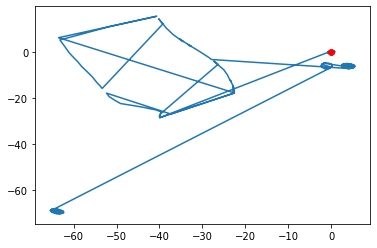

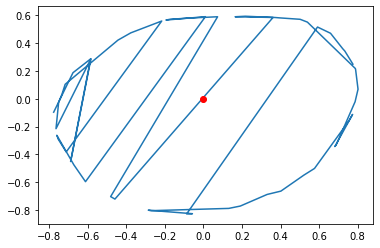

In [16]:
# Verify Gamma
plt.plot(pts_transformed[:,0], pts_transformed[:,1])
plt.plot([0],[0],'ro')
plt.show()

plt.plot(pts_filtered[:,0], pts_filtered[:,1])
plt.plot([0],[0],'ro')
plt.show()

In [17]:
# Build Background Mesh, Omega

# create background mesh
omega = function.Namespace()
centroid = lumen_polygon.Centroid()
diameter = lumen_polygon.EffectiveDiameter()
corner = L * diameter * np.ones([2])
omega_topo, omega.xi = im.Rectilinear(-corner, corner, [Nu,Nv])

# Define Inverse Plane Transformation Function
omega.M = function.asarray(M)
omega.origin = function.asarray(origin)
omega.x_j = 'M_ij xi_i + origin_j'

In [18]:
# Build Autoplaque Image Mesh, Alpha

# Extract subregion of autoplaque image
alpha = function.Namespace()
pA = origin - np.sqrt(2) * L * diameter * np.ones([3])
pB = origin + np.sqrt(2) * L * diameter * np.ones([3])
min_voxel_coords = autoplaque_img.VoxelCoordinates(pA)
max_voxel_coords = autoplaque_img.VoxelCoordinates(pB)
autoplaque_subimg = autoplaque_img.SubImage(min_voxel_coords, max_voxel_coords)

# convert to mesh
alpha_topo, alpha.x = autoplaque_subimg.ToNutilsMesh()

In [19]:
# Build Immersed Lumen Mesh, Beta

# convert vtk mesh to trimesh
lumen_tri_mesh = im.IM_TriMesh_CreateFromVTKMesh(lumen_mesh)

# create bounding volume
a = origin - L * diameter * np.ones([3])
b = origin + L * diameter * np.ones([3])
aabb = im.IM_AABB(a, b)

# Trim Lumen mesh by bounding volume
lumen_tri_mesh.TrimByAABB(aabb)

# convert trimesh to nutils mesh
beta = function.Namespace()
beta_topo, beta.x = lumen_tri_mesh.ToNutilsMesh()

In [20]:
# Construct material property functions on Alpha

# Convert Images to Functions
alpha.A = im.VoxelImageFunction(autoplaque_img, alpha.x[0], alpha.x[1], alpha.x[2])
alpha.W = im.BilinearVoxelImageFunction(wallsdf_img, alpha.x[0], alpha.x[1], alpha.x[2])

# build material properties label function in 3d
alpha.L0 = MaterialPropertiesLabel(material_model, alpha.W, alpha.A)

# build scaled representation
scaled_tissue_map = ScaleTissueMap(material_model.tissue_map)
alpha.Ls0 = im.LabelMapFunc(scaled_tissue_map, alpha.L0)

# Create Label Map Functions for Material Properties
alpha.nu0 = im.LabelMapFunc(material_model.nu_map, alpha.L0)
alpha.E0 = im.LabelMapFunc(material_model.E_map, alpha.L0)

# Define Lame Parameters
alpha.mu0 = 'E0 / (2 (1 + nu0))'
alpha.lmbda0 = 'E0 nu0 / ( (1 + nu0) (1 - 2 nu0) )'

# project material properties
alpha.convbasis = alpha_topo.basis('spline', p_conv)
alpha.mu = alpha_topo.projection(alpha.mu0, onto=alpha.convbasis, geometry=alpha.x, ptype='convolute', ischeme='gauss{}'.format(2 * p_conv))
alpha.lmbda = alpha_topo.projection(alpha.lmbda0, onto=alpha.convbasis, geometry=alpha.x, ptype='convolute', ischeme='gauss{}'.format(2 * p_conv))
alpha.E = alpha_topo.projection(alpha.E0, onto=alpha.convbasis, geometry=alpha.x, ptype='convolute', ischeme='gauss{}'.format(2 * p_conv))
alpha.nu = alpha_topo.projection(alpha.nu0, onto=alpha.convbasis, geometry=alpha.x, ptype='convolute', ischeme='gauss{}'.format(2 * p_conv))
alpha.Ls = alpha_topo.projection(alpha.Ls0, onto=alpha.convbasis, geometry=alpha.x, ptype='convolute', ischeme='gauss{}'.format(2 * p_conv))

project > constrained 10143/10143 dofs
project > constrained 10143/10143 dofs
project > constrained 10143/10143 dofs
project > constrained 10143/10143 dofs
project > constrained 10143/10143 dofs


In [ ]:
# Verify Alpha
print(alpha_topo)
im.WriteVTK(alpha_topo, alpha.x, {"Ls0" : alpha.Ls0, "Ls" : alpha.Ls, "A" : alpha.A, "W" : alpha.W, "E0" : alpha.E0, "E" : alpha.E}, 5, "verify_alpha")

In [21]:
# Refine Mesh and Quadrature

# create Indicator function inside lumen slice
omega.I = im.PolygonInclusion(lumen_polygon, -1, 1, omega.xi[0], omega.xi[1])

# create distance field for lumen mesh
omega.D = im.PolygonClosestPoint(lumen_polygon, omega.xi[0], omega.xi[1])

# create signed distance field for lumen mesh
omega.sdf = 'I D'

# refine background topology for basis
refined_omega_topo = im.RefineVoxelMeshBySDF(omega_topo, omega.sdf, nref, delta=delta)
omega.basis = refined_omega_topo.basis('th-spline', degree = p)

# refine background topology for quadrature rule
refined_quadrature_topo = im.RefineVoxelMeshBySDF(refined_omega_topo, omega.sdf, nqref, delta=delta)

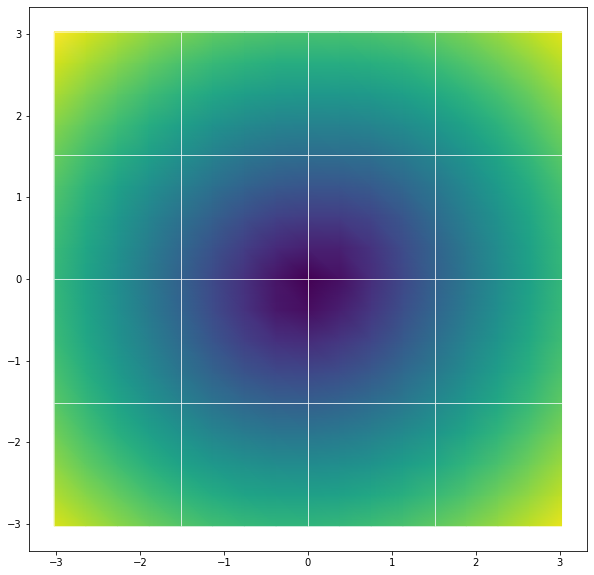

In [22]:
# Verify omega
PlotMesh(refined_omega_topo, omega.xi, omega.sdf, n=5, col='w')

In [23]:
bez = omega_topo.sample('gauss',2)
vals = bez.eval(omega.x)
print("omega : ")
print([min(vals[:,i]) for i in range(3)])
print([max(vals[:,i]) for i in range(3)])
bez = alpha_topo.sample('gauss',2)
vals = bez.eval(alpha.x)
print("alpha : ")
print([min(vals[:,i]) for i in range(3)])
print([max(vals[:,i]) for i in range(3)])

omega : 
[36.62709825798451, -183.29442342505084, 632.3556971960089]
[42.07340379698933, -182.47914815133007, 637.8597214208424]
alpha : 
[34.94131866081014, -187.45763933918983, 630.7670590179588]
[43.965263339189875, -178.43369466081012, 639.3985169820411]


In [24]:
print(omega_topo)
print(refined_omega_topo)
print(alpha_topo)
import inspect
inspect.getmro(type(alpha_topo))

StructuredTopology(2x2)
HierarchicalTopology(#16)
StructuredTopology(20x20x22)


(nutils.topology.StructuredTopology,
 nutils.topology.Topology,
 nutils.types.Singleton,
 nutils.types.Immutable,
 object)

In [25]:
# Build samples
gauss_omega = refined_quadrature_topo.sample('gauss', q)
bez_omega = refined_omega_topo.sample('bezier', res)
gauss_gamma = gamma_topo.sample('gauss', qu)

In [26]:
# Construct material property functions on Omega

# map samples
geom0, scale = im.GetAffineTransformation(alpha_topo, alpha.x)
gauss_alpha = im.LocateRectilinearSample(gauss_omega, omega.x, geom0, scale, alpha_topo)
boundary_gauss_omega = im.locatesample(gauss_gamma, gamma.xi, refined_omega_topo, omega.xi, 1e-7)

# convert evaluated samples on alpha to functions on omega at gauss points
omega.Enoblood = im.AsFunction(gauss_alpha, alpha.E, gauss_omega)
omega.lmbdanoblood = im.AsFunction(gauss_alpha, alpha.lmbda, gauss_omega)
omega.munoblood = im.AsFunction(gauss_alpha, alpha.mu, gauss_omega)


# overwrite blood region at gauss points
omega.indicator = im.PolygonInclusion(lumen_polygon, 0, 1, omega.xi[0], omega.xi[1])
omega.Eblood = material_model.E("blood")
omega.nublood = material_model.nu("blood")
omega.mublood = 'Eblood / (2 (1 + nublood))'
omega.lmbdablood = 'Eblood nublood / ( (1 + nublood) (1 - 2 nublood) )'
omega.E = 'indicator Enoblood + (1 - indicator) Eblood'
omega.mu = 'indicator munoblood + (1 - indicator) mublood'
omega.lmbda = 'indicator lmbdanoblood + (1 - indicator) lmbdablood'

optimize > constrained 40/72 dofs
optimize > optimum value 0.00e+00
solve > solving 32 dof system to machine precision using arnoldi solver
solve > solver returned with residual 4e-12
Young's Modulus range = [0.002, 7.068176928685839]


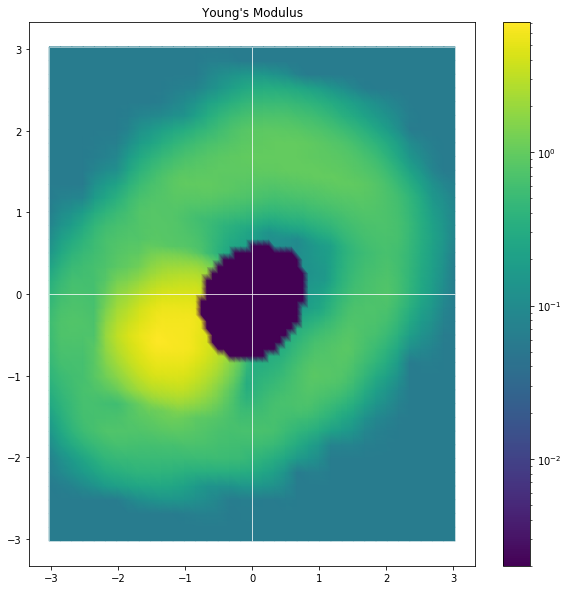

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Poisson Ratio range = [0.0, 0.40000000000000024]


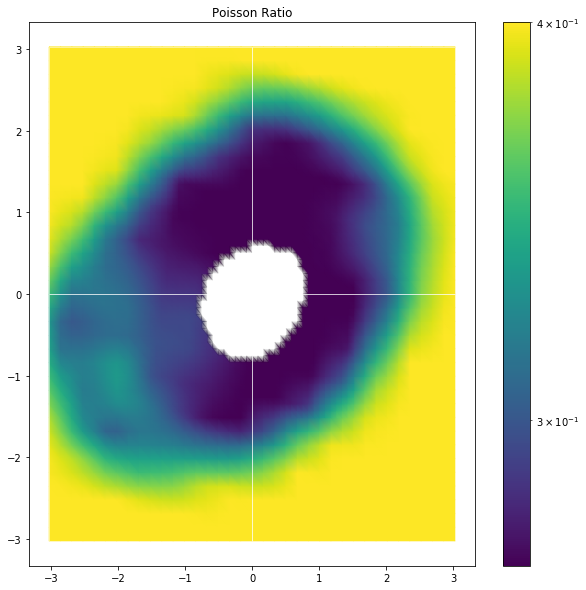

project > constrained 25/25 dofs
project > constrained 25/25 dofs
project > constrained 25/25 dofs
Displacement range = [0.0, 5106.126122052002]


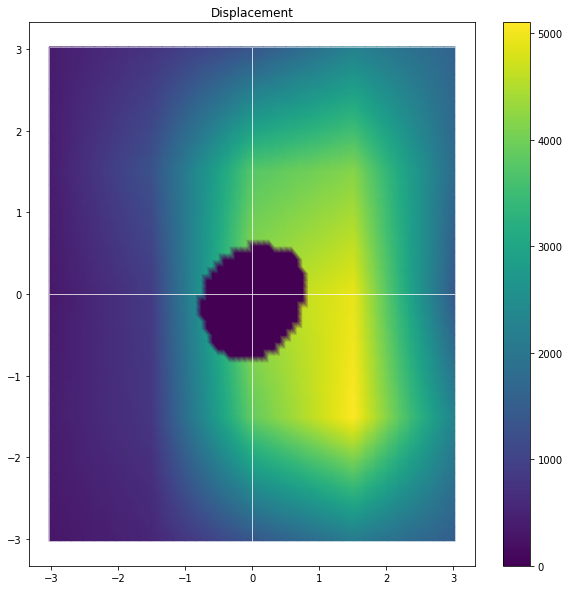

Meanstress range = [-383.39782662040415, 389.4448556874037]


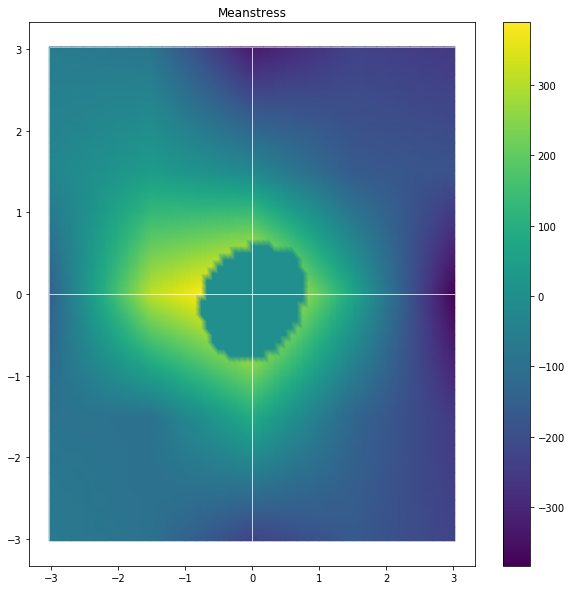

Von Mises range = [0.0, 2473.237927058124]


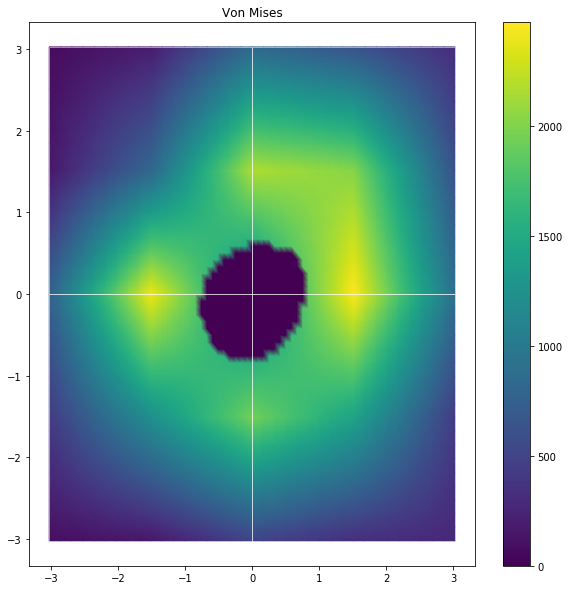

In [161]:
# define analysis
omega.traction = im.AsFunction(gauss_gamma, gamma.traction, boundary_gauss_omega)
omega.Jgamma = im.AsFunction(gauss_gamma, function.J(gamma.xi), boundary_gauss_omega)
omega.ubasis = omega.basis.vector(2)
omega.u_i = 'ubasis_ni ?lhs_n'
omega.X_i = 'xi_i + u_i'
omega.strain_ij = '( d(u_i, xi_j) + d(u_j, xi_i) ) / 2'
omega.stress_ij = 'lmbda strain_kk δ_ij + 2 mu strain_ij'
omega.meanstress = 'stress_kk / 3'
omega.S_ij = 'stress_ij - (stress_kk) δ_ij / 3'
omega.vonmises = 'sqrt(3 S_ij S_ij / 2)'
omega.disp = 'sqrt(u_i u_i)'
omega.r = 'sqrt( xi_i xi_i )'
omega.cos = 'xi_0 / r'
omega.sin = 'xi_1 / r'
omega.Qinv_ij = '< < cos , sin >_j , < -sin , cos >_j >_i'
omega.sigma_kl = 'stress_ij Qinv_kj Qinv_li '
omega.ubar_i = 'Qinv_ij u_j'
omega.eps_kl =  'strain_ij Qinv_kj Qinv_li '
omega.sigmatt = 'sigma_11'
omega.sigmarr = 'sigma_00'
omega.ur = 'ubar_0'

# Stiffness Matrix
K = gauss_omega.integral('d(ubasis_ni, xi_j) stress_ij d:xi' @ omega)

# Force Vector
F = boundary_gauss_omega.integral('traction_i Jgamma ubasis_ni' @ omega)

# Constrain Omega
sqr  = refined_omega_topo.boundary['left'].integral('u_i u_i d:xi' @ omega, degree = 2*p)
sqr += refined_omega_topo.boundary['bottom'].integral('u_i u_i d:xi' @ omega, degree = 2*p)
sqr += refined_omega_topo.boundary['top'].integral('u_i u_i d:xi' @ omega, degree = 2*p)
sqr += refined_omega_topo.boundary['right'].integral('u_i u_i d:xi' @ omega, degree = 2*p)
cons = solver.optimize('lhs', sqr, droptol=1e-15)

# Solve
lhs = solver.solve_linear('lhs', residual=K-F, constrain=cons)

# plot sample
bez = refined_quadrature_topo.sample('bezier', res)
bez_alpha = im.LocateRectilinearSample(bez, omega.x, geom0, scale, alpha_topo)

# define plotting functions
ns = function.Namespace()
ns.xi = omega.xi
ns.x = omega.x

ns.A = im.AsFunction(bez_alpha, alpha.A, bez)
ns.W = im.AsFunction(bez_alpha, alpha.W, bez)

ns.E0noblood = im.AsFunction(bez_alpha, alpha.E0, bez)
ns.nu0noblood = im.AsFunction(bez_alpha, alpha.nu0, bez)
ns.lmbda0noblood = im.AsFunction(bez_alpha, alpha.lmbda0, bez)
ns.mu0noblood = im.AsFunction(bez_alpha, alpha.mu0, bez)
ns.Ls0noblood = im.AsFunction(bez_alpha, alpha.Ls0, bez)

ns.Enoblood = im.AsFunction(bez_alpha, alpha.E, bez)
ns.nunoblood = im.AsFunction(bez_alpha, alpha.nu, bez)
ns.lmbdanoblood = im.AsFunction(bez_alpha, alpha.lmbda, bez)
ns.munoblood = im.AsFunction(bez_alpha, alpha.mu, bez)
ns.Lsnoblood = im.AsFunction(bez_alpha, alpha.Ls, bez)

ns.indicator = im.PolygonInclusion(lumen_polygon, 0, 1, omega.xi[0], omega.xi[1])
ns.Eblood = material_model.E("blood")
ns.nublood = material_model.nu("blood")
ns.mublood = 'Eblood / (2 (1 + nublood))'
ns.lmbdablood = 'Eblood nublood / ( (1 + nublood) (1 - 2 nublood) )'

ns.E0 = 'indicator E0noblood + (1 - indicator) Eblood'
ns.nu0 = 'indicator nu0noblood + (1 - indicator) nublood'
ns.mu0 = 'indicator mu0noblood + (1 - indicator) mublood'
ns.lmbda0 = 'indicator lmbda0noblood + (1 - indicator) lmbdablood'
ns.Ls0 = 'indicator Ls0noblood + (1 - indicator) lmbdablood'

ns.E = 'indicator Enoblood + (1 - indicator) Eblood'
ns.nu = 'indicator nunoblood + (1 - indicator) nublood'
ns.mu = 'indicator munoblood + (1 - indicator) mublood'
ns.lmbda = 'indicator lmbdanoblood + (1 - indicator) lmbdablood'
ns.Ls = 'indicator Lsnoblood + (1 - indicator) lmbdablood'

ns.basis = omega.basis
ns.ubasis = ns.basis.vector(2)
ns.u_i = 'ubasis_ni ?lhs_n'
ns.X_i = 'xi_i + u_i'
ns.strain_ij = '( d(u_i, xi_j) + d(u_j, xi_i) ) / 2'
ns.stress_ij = 'lmbda strain_kk δ_ij + 2 mu strain_ij'
ns.meanstress = 'stress_kk / 3'
ns.S_ij = 'stress_ij - (stress_kk) δ_ij / 3'
ns.vonmises = 'sqrt(3 S_ij S_ij / 2)'
ns.disp = 'sqrt(u_i u_i)'
ns.r = 'sqrt( xi_i xi_i )'
ns.cos = 'xi_0 / r'
ns.sin = 'xi_1 / r'
ns.Qinv_ij = '< < cos , sin >_j , < -sin , cos >_j >_i'
ns.sigma_kl = 'stress_ij Qinv_kj Qinv_li '
ns.ubar_i = 'Qinv_ij u_j'
ns.eps_kl =  'strain_ij Qinv_kj Qinv_li '
ns.sigmatt = 'sigma_11'
ns.sigmarr = 'sigma_00'
ns.ur = 'ubar_0'

# evaluate wireframe
omega_verts = omega_topo.sample('bezier',2)
verts = omega_verts.eval(omega.xi)
lines = np.array([ verts[omega_verts.hull[i]] for i in range(len(omega_verts.hull))])

# evaluate geometry
xvals = bez.eval(ns.xi)

# plot mesh
# fig, ax = im.CreatePlot(title="Autoplaque Image")
# vals = bez.eval(ns.A)
# ax.tripcolor(xvals[:,0], xvals[:,1], bez.tri, vals, shading='gouraud', rasterized=True)
# ax.add_collection(collections.LineCollection(lines, colors='w', linewidth=0.5, alpha=1))
# plt.show()

# plot mesh
# fig, ax = im.CreatePlot(title="Implicit Outer Wall Image")
# vals = bez.eval(ns.W)
# ax.tripcolor(xvals[:,0], xvals[:,1], bez.tri, vals, shading='gouraud', rasterized=True)
# ax.add_collection(collections.LineCollection(lines, colors='w', linewidth=0.5, alpha=1))
# plt.show()

# plot mesh
# fig, ax = im.CreatePlot(title="Material Labels (no blood)")
# vals = bez.eval(ns.Ls0noblood)
# ax.tripcolor(xvals[:,0], xvals[:,1], bez.tri, vals, shading='gouraud', rasterized=True)
# ax.add_collection(collections.LineCollection(lines, colors='w', linewidth=0.5, alpha=1))
# plt.show()

# plot mesh
# fig, ax = im.CreatePlot(title="Projected Material Labels (no blood)")
# vals = bez.eval(ns.Lsnoblood)
# ax.tripcolor(xvals[:,0], xvals[:,1], bez.tri, vals, shading='gouraud', rasterized=True)
# ax.add_collection(collections.LineCollection(lines, colors='w', linewidth=0.5, alpha=1))
# plt.show()

# plot mesh
# fig, ax = im.CreatePlot(title="Blood Indicator Function")
# vals = bez.eval(ns.indicator)
# ax.tripcolor(xvals[:,0], xvals[:,1], bez.tri, vals, shading='gouraud', rasterized=True)
# ax.add_collection(collections.LineCollection(lines, colors='w', linewidth=0.5, alpha=1))
# plt.show()

# plot mesh
# fig, ax = im.CreatePlot(title="Material Labels")
# vals = bez.eval(ns.Ls)
# ax.tripcolor(xvals[:,0], xvals[:,1], bez.tri, vals, shading='gouraud', rasterized=True)
# ax.add_collection(collections.LineCollection(lines, colors='w', linewidth=0.5, alpha=1))
# plt.show()

# plot youngs modulus
title = "Young's Modulus"
fig, ax = im.CreatePlot(title=title)
vals = bez.eval(ns.E)
print(title + " range = " + str([np.min(vals),np.max(vals)]))
triplot = ax.tripcolor(xvals[:,0], xvals[:,1], bez.tri, vals, shading='gouraud', rasterized=True, norm=colors.LogNorm())
ax.add_collection(collections.LineCollection(lines, colors='w', linewidth=0.5, alpha=1))
fig.colorbar(triplot)
plt.show()
WriteTriMesh("mesh_E.txt", xvals=xvals, fvals=vals, tri=bez.tri)


# plot poisson ratio
title = "Poisson Ratio"
fig, ax = im.CreatePlot(title=title)
vals = bez.eval(ns.nu)
print(title + " range = " + str([np.min(vals),np.max(vals)]))
triplot = ax.tripcolor(xvals[:,0], xvals[:,1], bez.tri, vals, shading='gouraud', rasterized=True, norm=colors.LogNorm())
ax.add_collection(collections.LineCollection(lines, colors='w', linewidth=0.5, alpha=1))
fig.colorbar(triplot)
plt.show()

# Post processed results

# projection gauss points sample
proj_gauss_omega = refined_omega_topo.sample('gauss', 2 * p_conv)
proj_gauss_alpha = im.LocateRectilinearSample(proj_gauss_omega, omega.x, geom0, scale, alpha_topo)

# define plotting functions
pp = function.Namespace()
pp.xi = omega.xi
pp.x = omega.x

pp.A = im.AsFunction(proj_gauss_alpha, alpha.A, proj_gauss_omega)
pp.W = im.AsFunction(proj_gauss_alpha, alpha.W, proj_gauss_omega)

pp.E0noblood = im.AsFunction(proj_gauss_alpha, alpha.E0, proj_gauss_omega)
pp.nu0noblood = im.AsFunction(proj_gauss_alpha, alpha.nu0, proj_gauss_omega)
pp.lmbda0noblood = im.AsFunction(proj_gauss_alpha, alpha.lmbda0, proj_gauss_omega)
pp.mu0noblood = im.AsFunction(proj_gauss_alpha, alpha.mu0, proj_gauss_omega)
pp.Ls0noblood = im.AsFunction(proj_gauss_alpha, alpha.Ls0, proj_gauss_omega)

pp.Enoblood = im.AsFunction(proj_gauss_alpha, alpha.E, proj_gauss_omega)
pp.nunoblood = im.AsFunction(proj_gauss_alpha, alpha.nu, proj_gauss_omega)
pp.lmbdanoblood = im.AsFunction(proj_gauss_alpha, alpha.lmbda, proj_gauss_omega)
pp.munoblood = im.AsFunction(proj_gauss_alpha, alpha.mu, proj_gauss_omega)
pp.Lsnoblood = im.AsFunction(proj_gauss_alpha, alpha.Ls, proj_gauss_omega)

pp.indicator = im.PolygonInclusion(lumen_polygon, 0, 1, omega.xi[0], omega.xi[1])
pp.Eblood = material_model.E("blood")
pp.nublood = material_model.nu("blood")
pp.mublood = 'Eblood / (2 (1 + nublood))'
pp.lmbdablood = 'Eblood nublood / ( (1 + nublood) (1 - 2 nublood) )'

pp.E0 = 'indicator E0noblood + (1 - indicator) Eblood'
pp.nu0 = 'indicator nu0noblood + (1 - indicator) nublood'
pp.mu0 = 'indicator mu0noblood + (1 - indicator) mublood'
pp.lmbda0 = 'indicator lmbda0noblood + (1 - indicator) lmbdablood'
pp.Ls0 = 'indicator Ls0noblood + (1 - indicator) lmbdablood'

pp.E = 'indicator Enoblood + (1 - indicator) Eblood'
pp.nu = 'indicator nunoblood + (1 - indicator) nublood'
pp.mu = 'indicator munoblood + (1 - indicator) mublood'
pp.lmbda = 'indicator lmbdanoblood + (1 - indicator) lmbdablood'
pp.Ls = 'indicator Lsnoblood + (1 - indicator) lmbdablood'

pp.basis = omega.basis
pp.ubasis = pp.basis.vector(2)
pp.u_i = 'ubasis_ni ?lhs_n'
pp.X_i = 'xi_i + u_i'
pp.strain_ij = '( d(u_i, xi_j) + d(u_j, xi_i) ) / 2'
pp.stress_ij = 'lmbda strain_kk δ_ij + 2 mu strain_ij'
pp.meanstress = 'stress_kk / 3'
pp.S_ij = 'stress_ij - (stress_kk) δ_ij / 3'
pp.vonmises = 'sqrt(3 S_ij S_ij / 2)'
pp.disp = 'sqrt(u_i u_i)'
pp.r = 'sqrt( xi_i xi_i )'
pp.cos = 'xi_0 / r'
pp.sin = 'xi_1 / r'
pp.Qinv_ij = '< < cos , sin >_j , < -sin , cos >_j >_i'
pp.sigma_kl = 'stress_ij Qinv_kj Qinv_li '
pp.ubar_i = 'Qinv_ij u_j'
pp.eps_kl =  'strain_ij Qinv_kj Qinv_li '
pp.sigmatt = 'sigma_11'
pp.sigmarr = 'sigma_00'
pp.ur = 'ubar_0'

# convolute projection post processing
proj_basis = refined_omega_topo.basis('th-spline', degree=p_conv)
pp.vonmisesproj = refined_omega_topo.projection('vonmises' @ pp(lhs=lhs), onto=proj_basis, geometry=ns.xi, ptype='convolute', ischeme='gauss{}'.format(2 * p_conv))
pp.dispproj = refined_omega_topo.projection('disp' @ pp(lhs=lhs), onto=proj_basis, geometry=ns.xi, ptype='convolute', ischeme='gauss{}'.format(2 * p_conv))
pp.meanstressproj = refined_omega_topo.projection('meanstress' @ pp(lhs=lhs), onto=proj_basis, geometry=ns.xi, ptype='convolute', ischeme='gauss{}'.format(2 * p_conv))

# overwrite blood domain
pp.vonmisesnoblood = 'indicator vonmisesproj'
pp.dispnoblood = 'indicator dispproj'
pp.meanstressnoblood = 'indicator meanstressproj'

# post processed plots
title = "Displacement"
fig, ax = im.CreatePlot(title=title)
vals = bez.eval("dispnoblood" @ pp)
print(title + " range = " + str([np.min(vals),np.max(vals)]))
triplot = ax.tripcolor(xvals[:,0], xvals[:,1], bez.tri, vals, shading='gouraud', rasterized=True)
ax.add_collection(collections.LineCollection(lines, colors='w', linewidth=0.5, alpha=1))
fig.colorbar(triplot)
plt.show()

# post processed plots
title = "Meanstress"
fig, ax = im.CreatePlot(title=title)
vals = bez.eval("meanstressnoblood" @ pp)
print(title + " range = " + str([np.min(vals),np.max(vals)]))
triplot = ax.tripcolor(xvals[:,0], xvals[:,1], bez.tri, vals, shading='gouraud', rasterized=True)
ax.add_collection(collections.LineCollection(lines, colors='w', linewidth=0.5, alpha=1))
fig.colorbar(triplot)
plt.show()

# post processed plots
title = "Von Mises"
fig, ax = im.CreatePlot(title=title)
vals = bez.eval("vonmisesnoblood" @ pp)
print(title + " range = " + str([np.min(vals),np.max(vals)]))
triplot = ax.tripcolor(xvals[:,0], xvals[:,1], bez.tri, vals, shading='gouraud', rasterized=True)
ax.add_collection(collections.LineCollection(lines, colors='w', linewidth=0.5, alpha=1))
fig.colorbar(triplot)
plt.show()

In [ ]:
# plot mesh
ns.Wh = im.Heaviside(-1e-7, 1,1,0, ns.W)
ax = im.CreatePlot(title="Mesh")
vals = bez.eval(ns.Wh)
ax.tripcolor(xvals[:,0], xvals[:,1], bez.tri, vals, shading='gouraud', rasterized=True)
ax.add_collection(collections.LineCollection(lines, colors='w', linewidth=0.5, alpha=1))
plt.show()

In [129]:
print(verts)
print(bez.tri)

[[  36.93096388 -183.39076534  631.61829777]
 [  36.90225466 -183.39112323  631.78379721]
 [  36.87354543 -183.39148113  631.94929665]
 ...
 [  40.58860383 -182.63443812  636.68691564]
 [  40.57424921 -182.63461707  636.76966536]
 [  40.5598946  -182.63479601  636.85241508]]
[[   0    1   10]
 [   1   10   11]
 [   1    2   11]
 ...
 [2788 2797 2798]
 [2788 2789 2798]
 [2789 2798 2799]]


In [121]:
tris = [[[0,0,0],[1,0,0],[1,1,0]],[[1,1,0],[1,1,1],[0.5,0.5,0]]]

In [ ]:
verts = bez.eval(ns.x)
tris = [[verts[v] for v in tri] for tri in bez.tri]

In [122]:
ply = Poly3DCollection(tris, facecolors='r', linewidths=1)

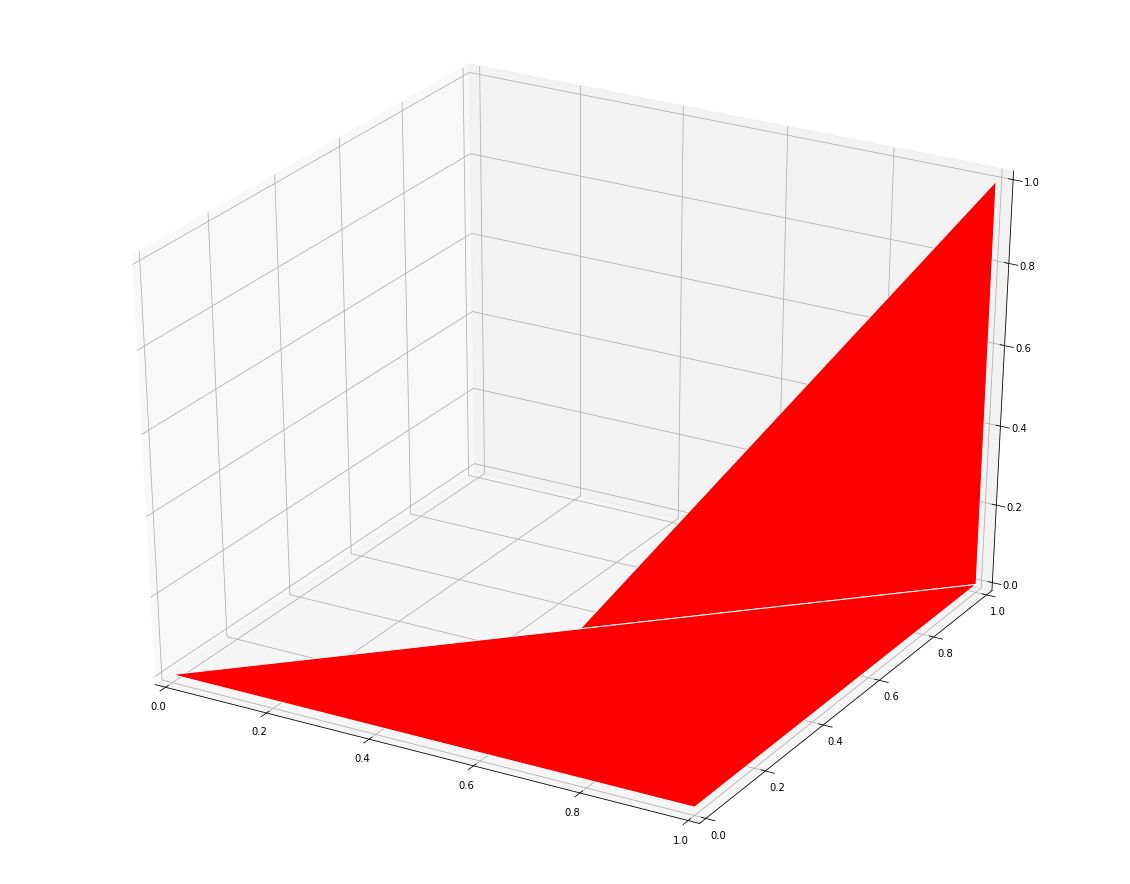

In [125]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection='3d')
ax.add_collection3d(Poly3DCollection(tris, facecolors='r', edgecolors='w',linewidths=1))

In [110]:
print(verts)

[[  36.93096388 -183.39076534  631.61829777]
 [  36.90225466 -183.39112323  631.78379721]
 [  36.87354543 -183.39148113  631.94929665]
 ...
 [  40.58860383 -182.63443812  636.68691564]
 [  40.57424921 -182.63461707  636.76966536]
 [  40.5598946  -182.63479601  636.85241508]]


In [111]:
print(bez.eval(ns.x))

[[  36.93096388 -183.39076534  631.61829777]
 [  36.90225466 -183.39112323  631.78379721]
 [  36.87354543 -183.39148113  631.94929665]
 ...
 [  40.58860383 -182.63443812  636.68691564]
 [  40.57424921 -182.63461707  636.76966536]
 [  40.5598946  -182.63479601  636.85241508]]


In [112]:
print(bez.tri)

[[   0    1   10]
 [   1   10   11]
 [   1    2   11]
 ...
 [2788 2797 2798]
 [2788 2789 2798]
 [2789 2798 2799]]


In [114]:
print(tris[0])

[array([  36.93096388, -183.39076534,  631.61829777]), array([  36.90225466, -183.39112323,  631.78379721]), array([  37.09407795, -183.36240858,  631.64665453])]


In [107]:
print(verts[0])

[[  36.93096388 -183.39076534  631.61829777]
 [  36.90225466 -183.39112323  631.78379721]
 [  37.09407795 -183.36240858  631.64665453]]
